In [73]:
import pandas as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

import warnings
warnings.filterwarnings('ignore')

## Getting our Data 
- This is an adapted version of the code we used in our MTA Pairs
- With this we can pull the data from our selected months, and concatenate them into a single database
- 

In [4]:
def get_mta_data(list_of_dates):
    '''
    Here is a function to take in all of the data from the MTA website
        (this is an expanded version of our MTA pair cleaning)
    
    It will also convert it into a more "readable" format
    
    Finally, I will concatenate all of the weeks I plan to target into a single DB
    '''
    combined_df = pd.DataFrame()
    
    root_url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
     
    for date in list_of_dates:
        # represents a url link matching each date provided
        MTA_url = f'{root_url}{date}.txt'
        # This will allow Pandas to read our dataframe
        dataset = pd.read_csv(MTA_url)
        # concatenate into a single dataframe 
        combined_df = pd.concat([combined_df, dataset], ignore_index = True) #ignore existing indices
    
    return combined_df

In [5]:
def all_SAT(year):
    '''
    Takes in a year yyyy and returns all the saturdays in yyyy
    This will give us a bit of overlap and help separate my
    weekdays from my weekends
    '''
    return pd.date_range(start=str(year), end=str(year+1), 
                         freq='W-SAT').strftime('%y%m%d').tolist()

In [9]:
def month_filter(list_of_dates, list_of_months):
#This will return a list of dates that contains my (3) targeted  months 
    dates_for_months = []
    for month in list_of_months:
        filtered_dates = list(filter(lambda x: (x[2:4] in month), list_of_dates))
        dates_for_months += filtered_dates
    
    return dates_for_months

In [13]:
# Create a list of dates (SATURDAY) for the year of 2019
sat_2019 = all_SAT(2019)

#filtering to my targeted months April, May, June
months_of_interest = ['04', '05', '06']
april_may_june_19 = month_filter(sat_2019, months_of_interest)

# Finally lets use our function to get the data from the MTA website and assign to a DF
spring19_MTA = get_mta_data(april_may_june_19)
spring19_MTA.head() #quick check to make sure everything looks okay
#note that there is a slight overlap into march as I opted to take in all Saturdays

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,00:00:00,REGULAR,6999064,2373568
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781


In [15]:
#getting a summary of our dataframe and its data types
spring19_MTA.info()
#this will show the initial number of datapoints before cleaning
print(f'total data points:{np.shape(spring19_MTA)[0]}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664248 entries, 0 to 2664247
Data columns (total 11 columns):
 #   Column                                                                Dtype 
---  ------                                                                ----- 
 0   C/A                                                                   object
 1   UNIT                                                                  object
 2   SCP                                                                   object
 3   STATION                                                               object
 4   LINENAME                                                              object
 5   DIVISION                                                              object
 6   DATE                                                                  object
 7   TIME                                                                  object
 8   DESC                                                          

In [16]:
#Lets take a look at our column names. 
spring19_MTA.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [17]:
'''
As we can see, we have a bunch of extra whitespace before exits
    -this is a quick command to strip all of that out
'''
spring19_MTA.columns = spring19_MTA.columns.str.strip()

In [19]:
spring19_MTA['Unique_Station'] = spring19_MTA['STATION'] + '_' + spring19_MTA['LINENAME']
#in order to make things a bit more unique, lets combine station and linename
#this will also help display more info on our visualizations

In [21]:
'''
If we look at our dataframe we can see that entries and exits display the total accumulated count over
a 4 hour period.

In order to get all of the new entries and exits over that period, we make two new columns for entries and 
exits and take the difference between the new column and the original

finally we add those two together, and that will give us the total traffic for each station
'''

spring19_MTA['ENTRIES DIFF'] = spring19_MTA['ENTRIES'].diff()
spring19_MTA['EXITS DIFF'] = spring19_MTA['EXITS'].diff()
spring19_MTA['Total_Traffic'] = spring19_MTA['ENTRIES DIFF'] + spring19_MTA['EXITS DIFF']

## Cleaning Negative Values and Removing Outliers




In [22]:
'''
-our dataframe has the date and time assinged to spearate columns, we can convert date and time info into a 
datetime object, which will allow us to do time-based operations

-Pandas also has the calendar import which will help us highlight specific days of the week.
    -this will give us the ability to separate our weekdays from the weekends

-my findDay function will allow us to take the data in its original format and return the day of the week
'''
import datetime
import calendar

def findDay(date): 
    mmddyy = datetime.datetime.strptime(date, '%m/%d/%Y').weekday() 
    return (calendar.day_name[mmddyy])

In [23]:
spring19_MTA['DAY_OF_WEEK'] = spring19_MTA['DATE'].apply(lambda date: findDay(date))
#lets add a day of the week column which will allow us to show what date of the week it is.

In [24]:
spring19_MTA.groupby('Unique_Station').sum().head(10)
'''
    Before we go any further, lets check the sum of the total traffic to see if we have any issues.
    
    -As we can see, we have some negative values in our total traffic, further exploration will 
     help us understand why
    
    -a box plot will be a great way to see if we have any very large outliers, which will mess with our data
    
'''    

,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic
Unique_Station,,,,,
1 AV_L,799849750681,828041356350,-5.677284e+07,-9.944337e+07,-1.562162e+08
103 ST-CORONA_7,39770511766,40001193343,5.963920e+07,1.046125e+08,1.642517e+08
103 ST_1,36123986643,19507779049,1.471258e+08,1.387234e+08,2.858493e+08
103 ST_6,283467824157,507193667658,-3.908337e+09,3.902927e+09,-5.409978e+06
103 ST_BC,16335771399,14068256692,6.274388e+07,1.079485e+08,1.706924e+08
104 ST_A,929908198748,544226211876,2.181723e+10,1.271053e+10,3.452776e+10
104 ST_JZ,1715206978839,1385219485966,4.322307e+07,5.862511e+07,1.018482e+08
110 ST_6,21024033135,20218237598,-4.293304e+09,-3.844511e+09,-8.137816e+09
111 ST_7,28809071524,17589378769,-2.965029e+06,-4.931508e+07,-5.228011e+07


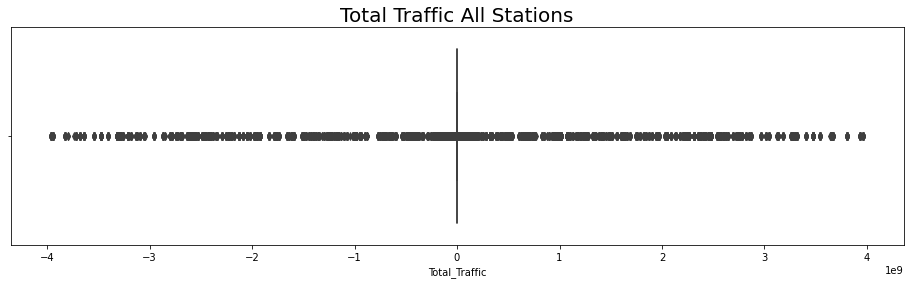

In [42]:
 '''
Just like in our pair programming, this quick gut check illustrates that we have some very large positive and 
negative values.

We should first remove all negative traffic

Then we can check our inter quartile ranges and develop a mask to filter out outliers
'''


plt.figure(figsize = [16,4])
sns.boxplot(spring19_MTA.Total_Traffic[1:]);
plt.title('Total Traffic All Stations', size = 20);
   
#There is a warning here, but I added a command to filter them out at the top

In [43]:
#we can address this by adding in a mask
mask = spring19_MTA['Total_Traffic'] > 0
spring19_MTA_pos = spring19_MTA[mask]


In [45]:
#calculating our quartiles using Numpy 
q25, q50, q75 = np.percentile(spring19_MTA.Total_Traffic[1:], [25, 50, 75])

#we need an inter quartile range to determine our min and max values
IQR = q75 - q25

# Anything outside of these values are outliers
min_traffic = q25 - (1.5 * IQR)
max_traffic = q75 + (1.5 * IQR)

#these are our values that will need to be filtered
print(min_traffic, max_traffic)

-627.5 1112.5


In [47]:
#we can take care of both the outliers, and the negative values using this mask
total_traffic_mask = ((spring19_MTA_pos['Total_Traffic'] > min_traffic) & (spring19_MTA_pos['Total_Traffic'] < max_traffic))
spring19_MTA_cleaned = spring19_MTA_pos[total_traffic_mask]

#lets check and see if our # of data points has changed
print(f'We have a total of {np.shape(spring19_MTA_cleaned)[0]} data points')
#quite the reduction!

We have a total of 2135517 data points


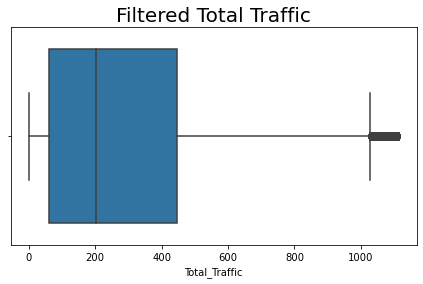

In [50]:
#Lets take a look at our boxplot again:
plt.figure(figsize = [16,4])

plt.subplot(1,2,2)
sns.boxplot(spring19_MTA_cleaned.Total_Traffic);
plt.title('Filtered Total Traffic', size = 20);

In [51]:
#very large numbers could present problems when we visualize our data. We can fix this by normalizing our data

tt_min = spring19_MTA_cleaned['Total_Traffic'].min()
tt_max = spring19_MTA_cleaned['Total_Traffic'].max()

spring19_MTA_cleaned['Total_Traffic'] = (spring19_MTA_cleaned.Total_Traffic - tt_min) / (tt_max - tt_min)

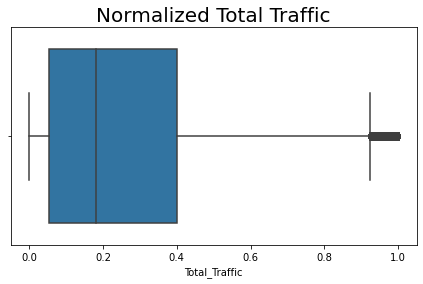

In [54]:
#Lets take a look at our box plot one last time. After normalization, our values should be between 0-1
plt.figure(figsize = [16,4])
plt.subplot(1,2,2)
sns.boxplot(spring19_MTA_cleaned.Total_Traffic);
plt.title('Normalized Total Traffic', size = 20);

In [55]:
spring19_MTA_cleaned.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Unique_Station,ENTRIES DIFF,EXITS DIFF,Total_Traffic,DAY_OF_WEEK
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576,59 ST_NQR456W,20.0,8.0,0.024302,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622,59 ST_NQR456W,23.0,46.0,0.061206,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710,59 ST_NQR456W,107.0,88.0,0.174617,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781,59 ST_NQR456W,237.0,71.0,0.276328,Saturday
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,20:00:00,REGULAR,6999796,2373837,59 ST_NQR456W,345.0,56.0,0.360036,Saturday


In [60]:
# lets turn our 4 hour windows into single integer values
spring19_MTA_cleaned['TIME_INT'] = spring19_MTA_cleaned['TIME'].apply(lambda x: int(x.split(':')[0]))

# when looking at a 24 hour clock as ints, we will run into a problem with midnight as it will come out as a 0.
#This will convert it, so we can still capture the late evening window 
spring19_MTA_cleaned['TIME_INT'][spring19_MTA_cleaned['TIME_INT'] == 0] = 23


In [61]:
#This will take our time integer and "bin" it so we can then assign it to a time of day

def Time_of_Day(df):
    bins = (0, 4, 8, 12, 16, 20, 23)
    group_names = ['Midnight-4AM','4AM-8AM', '8AM-Noon', 'Noon-4PM', '4PM-8PM', '8PM-Midnight']
    categories = pd.cut(df.TIME_INT, bins, labels=group_names, include_lowest = True)
    df['TIME_OF_DAY'] = categories
    return df

In [63]:
#applying my Time of Day function
Time_of_Day(spring19_MTA_cleaned);

In [68]:
spring19_MTA_cleaned.head(7)
#check to see if the column was added and if our labels match our ints

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Unique_Station,ENTRIES DIFF,EXITS DIFF,Total_Traffic,DAY_OF_WEEK,TIME_INT,TIME_OF_DAY,WEEKEND
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576,59 ST_NQR456W,20.0,8.0,0.024302,Saturday,4,Midnight-4AM,WEEKEND
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622,59 ST_NQR456W,23.0,46.0,0.061206,Saturday,8,4AM-8AM,WEEKEND
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710,59 ST_NQR456W,107.0,88.0,0.174617,Saturday,12,8AM-Noon,WEEKEND
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781,59 ST_NQR456W,237.0,71.0,0.276328,Saturday,16,Noon-4PM,WEEKEND
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,20:00:00,REGULAR,6999796,2373837,59 ST_NQR456W,345.0,56.0,0.360036,Saturday,20,4PM-8PM,WEEKEND
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,00:00:00,REGULAR,6999957,2373867,59 ST_NQR456W,161.0,30.0,0.171017,Sunday,23,8PM-Midnight,WEEKEND
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,04:00:00,REGULAR,6999983,2373876,59 ST_NQR456W,26.0,9.0,0.030603,Sunday,4,Midnight-4AM,WEEKEND


In [69]:
#Adding one more column which will allow us to separate weekends and weekdays
spring19_MTA_cleaned['WEEKEND'] = (spring19_MTA_cleaned['DAY_OF_WEEK']
                                   .apply(lambda x: 'WEEKEND' 
                                          if (x == 'Saturday' or x == 'Sunday') 
                                          else 'WEEKDAY'))

In [70]:
top = 10 #lets take a look at our top 10 stations and assign to a new var for visualization
top_stations = (spring19_MTA_cleaned.groupby(['Unique_Station'])
                       .sum()
                       .reset_index()
                       .sort_values(by = 'Total_Traffic', ascending = False)
                       .head(top))
top_stations


,Unique_Station,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
94,34 ST-PENN STA_ACE,670283993176,715364962094,5251396.0,4303253.0,8576.776778,347573
312,GRD CNTRL-42 ST_4567S,580325761542,537573481170,4457804.0,4385398.0,7936.803780,289547
90,34 ST-HERALD SQ_BDFMNQRW,976660703407,937652785399,4035201.0,4110163.0,7311.983798,275743
302,FULTON ST_2345ACJZ,306473275121,340456131519,4155459.0,3971517.0,7290.098110,327214
103,42 ST-PORT AUTH_ACENQRS1237W,1464593492427,1220246777724,3878724.0,2342674.0,5585.650765,198939
448,TIMES SQ-42 ST_1237ACENQRSW,1984085919748,1029532078965,2865069.0,2706036.0,5001.166517,184935
289,FLUSHING-MAIN_7,90929349471,87244537783,2884312.0,2427216.0,4770.527453,149095
235,CANAL ST_JNQRZ6W,881131763593,1543023208107,2771874.0,2370918.0,4616.092709,153690
124,59 ST_456NQRW,191775112849,122469424546,2147214.0,2413130.0,4091.318632,198612
404,PATH NEW WTC_1,1422459420,1673071952,2253297.0,2131509.0,3932.065707,201047


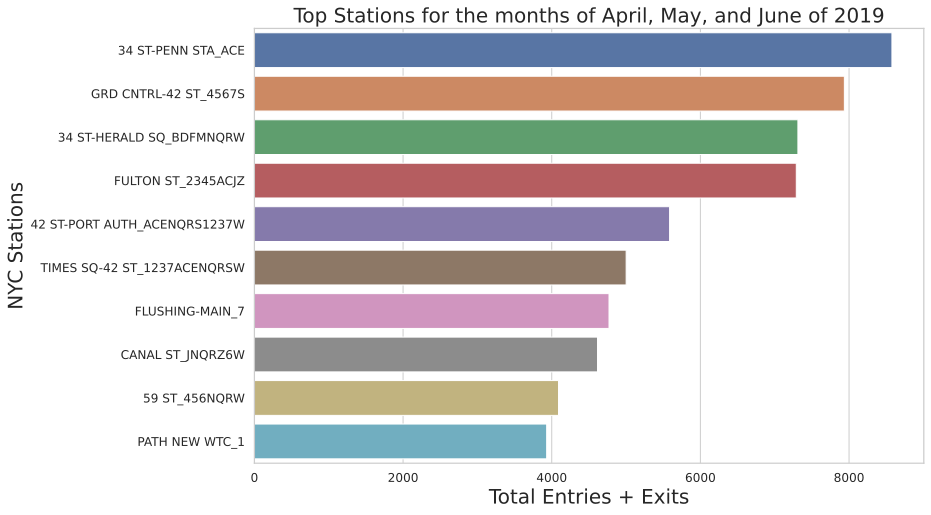

In [83]:
#lets take these top 10 stations and visualize them. A horizontal barplot should work well
plt.figure(figsize = [12,8])
sns.barplot(x = 'Total_Traffic', y = 'Unique_Station', data = top_stations)
plt.title('Top Stations for the months of April, May, and June of 2019', fontsize = 20)
plt.xlabel('Total Entries + Exits', fontsize = 20)
plt.ylabel('NYC Stations', fontsize = 20);

In [84]:
#this will display our traffic to compare with the weekdays
#I am going to assign weekends and weekdays to their own vars
top = 10 # going to keep things consistent and show 10 again
weekends = spring19_MTA_cleaned[spring19_MTA_cleaned['WEEKEND'] == 'WEEKEND']

top_unique_stations_weekends = (weekends.groupby(['Unique_Station'])
                       .sum()
                       .reset_index()
                       .sort_values(by = 'Total_Traffic', ascending = False)
                       .head(top))

top_unique_stations_weekends[['Unique_Station', 'Total_Traffic']]

,Unique_Station,Total_Traffic
90,34 ST-HERALD SQ_BDFMNQRW,1888.076508
312,GRD CNTRL-42 ST_4567S,1744.849685
94,34 ST-PENN STA_ACE,1708.066607
103,42 ST-PORT AUTH_ACENQRS1237W,1465.750675
448,TIMES SQ-42 ST_1237ACENQRSW,1181.265527
235,CANAL ST_JNQRZ6W,1135.490549
339,JKSN HT-ROOSVLT_EFMR7,1097.246625
25,14 ST-UNION SQ_LNQR456W,1083.328533
123,59 ST COLUMBUS_ABCD1,1061.417642
93,34 ST-PENN STA_123ACE,987.854185


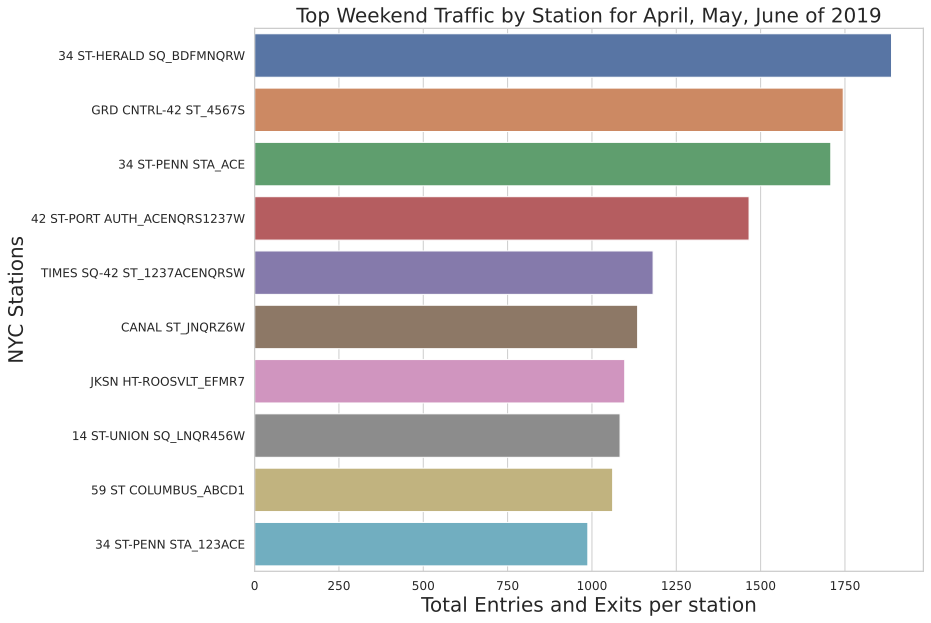

In [132]:
plt.figure(figsize = [12,10])
sns.barplot(x = 'Total_Traffic', y = 'Unique_Station', data = top_unique_stations_weekends)
plt.title('Top Weekend Traffic by Station for April, May, June of 2019', fontsize = 20)
plt.xlabel('Total Entries and Exits per station', fontsize = 20)
plt.ylabel('NYC Stations', fontsize = 20);

In [85]:
# Same thing, but for weekday traffic
top = 10 # keeping at 10 
weekdays = spring19_MTA_cleaned[spring19_MTA_cleaned['WEEKEND'] == 'WEEKDAY']

top_unique_stations_weekdays = (weekdays.groupby(['Unique_Station'])
                       .sum()
                       .reset_index()
                       .sort_values(by = 'Total_Traffic', ascending = False)
                       .head(top))

top_unique_stations_weekdays[['Unique_Station', 'Total_Traffic']]

,Unique_Station,Total_Traffic
94,34 ST-PENN STA_ACE,6868.710171
302,FULTON ST_2345ACJZ,6367.778578
312,GRD CNTRL-42 ST_4567S,6191.954095
90,34 ST-HERALD SQ_BDFMNQRW,5423.907291
103,42 ST-PORT AUTH_ACENQRS1237W,4119.900090
289,FLUSHING-MAIN_7,3885.751575
448,TIMES SQ-42 ST_1237ACENQRSW,3819.900990
404,PATH NEW WTC_1,3751.805581
235,CANAL ST_JNQRZ6W,3480.602160
124,59 ST_456NQRW,3258.932493


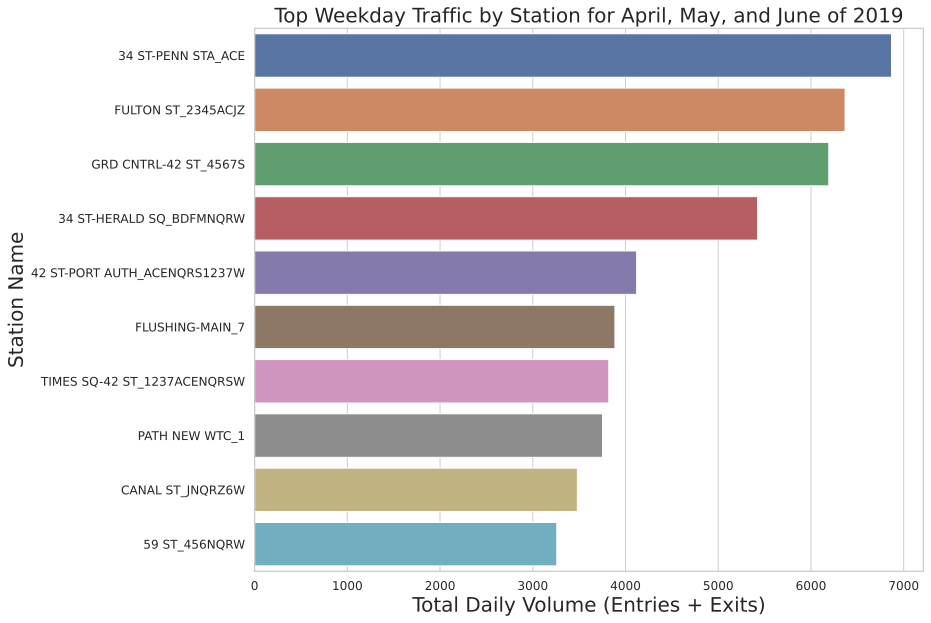

In [131]:
plt.figure(figsize = [12,10])
sns.barplot(x = 'Total_Traffic', y = 'Unique_Station', data = top_unique_stations_weekdays, )
plt.title('Top Weekday Traffic by Station for April, May, and June of 2019', fontsize = 20)
plt.xlabel('Total Daily Volume (Entries + Exits)', fontsize = 20)
plt.ylabel('Station Name', fontsize = 20);
plt.savefig('Top Stations Weekdays.png',facecolor = 'w', transparent = False)

## Weekend v. Weekday 
- As we can see, there are significantly less daily riders on the weekends. 
- Lets take a deeper look at the two so we can determine optimal exposure to NYC residents.

In [92]:
#lets group the sum of daily traffic by each day and visualize to see the actual trend
total_traffic_per_week = spring19_MTA_cleaned.groupby('DAY_OF_WEEK').sum()

,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
DAY_OF_WEEK,,,,,,
Friday,9110407454713,7041622732793,58232711.0,43018708.0,90851.060306,3915300
Monday,9164587769941,7107276277123,53643256.0,39778304.0,83805.571557,3901970
Saturday,7575870411015,5855446366739,33453313.0,26198029.0,53458.659766,3224421
Sunday,9136449754706,7124205641417,32774647.0,27370014.0,53855.558956,3936769
Thursday,8919831949247,6940603077978,58226326.0,42998915.0,90832.471647,3842948
Tuesday,9102669064148,7098131270579,57208242.0,42208177.0,89201.938794,3889080
Wednesday,9033961015501,7025969326268,58379814.0,43297221.0,91237.007201,3876883


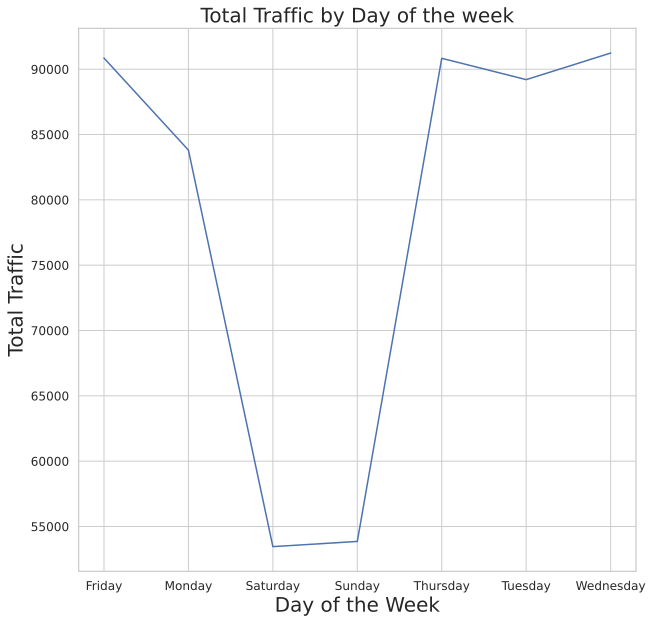

In [133]:
#A line plot will be the best tool for this
plt.figure(figsize = [10,10])
sns.lineplot(x = total_traffic_per_week.index , 
             y = total_traffic_per_week.Total_Traffic, 
             data = total_traffic_per_week.sort_values(by = 'Total_Traffic'));
plt.xlabel('Day of the Week', size = 20)
plt.ylabel('Total Traffic', size = 20)
plt.title('Total Traffic by Day of the week', size = 20);

#We can see that there is a significant reduction in ridership on the weekends

In [94]:
#Now I would like to look at the total traffic across all stations based on our 4 hour time windows
total_traffic_time_of_day = spring19_MTA_cleaned.groupby('TIME_OF_DAY').sum()
total_traffic_time_of_day.head()

,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
TIME_OF_DAY,,,,,,
Midnight-4AM,10359709599031,8094865621635,15892845.0,16666860.0,28995.439244,973032
4AM-8AM,11920298904913,9388816459917,35453281.0,22548278.0,51858.585059,2623818
8AM-Noon,10898662569650,8439194796158,80248377.0,55691165.0,122032.160216,3860278
Noon-4PM,10489836850110,8154102819392,79801205.0,59405207.0,124964.670567,5456243
4PM-8PM,8951575281510,6802211081851,85067950.0,61845144.0,131932.126913,6270559


## Heatmap
- In my proposal, I decided that a heatmap would be a great addition to my bar plot.
- In order to fit everything in one plot, I am going to look at total traffic across all stations 
- This should give us the best timeframe to assingn our street teams. 

In [134]:
'''
- The first step here is to assign our time of day to specific group names
- We can then group our day of week and time of day columns and get a sum for each one
- I will then create a brand new df specifically for my heatmap
'''
group_names = ['Midnight-4AM', '4AM-8AM', '8AM-Noon', 'Noon-4PM', '4PM-8PM', '8PM-Midnight']
total_traffic_time_of_day = spring19_MTA_cleaned.groupby(['DAY_OF_WEEK', 'TIME_OF_DAY']).sum().reset_index()
temp = total_traffic_time_of_day[['DAY_OF_WEEK', 'TIME_OF_DAY', 'Total_Traffic']]
temp.head(50)

DF_for_heatm = pd.DataFrame({'TIME_OF_DAY': group_names, 
                            'Monday': temp.iloc[6:12]['Total_Traffic'].values,
                            'Tuesday': temp.iloc[30:36]['Total_Traffic'].values,
                            'Wednesday': temp.iloc[36:42]['Total_Traffic'].values,
                            'Thursday': temp.iloc[24:30]['Total_Traffic'].values,
                            'Friday': temp.iloc[0:6]['Total_Traffic'].values,
                            'Saturday': temp.iloc[12:18]['Total_Traffic'].values,
                            'Sunday': temp.iloc[18:24]['Total_Traffic'].values
                           })
DF_for_heatm

,TIME_OF_DAY,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,Midnight-4AM,3250.526553,4086.226823,4571.477048,4815.814581,5049.921692,1804.792979,5416.679568
1,4AM-8AM,8791.835284,9388.177318,9721.990099,9224.481548,8974.081008,3335.212421,2422.807381
2,8AM-Noon,20029.055806,21198.774077,21104.288029,21021.487849,20757.111611,10277.581458,7643.861386
3,Noon-4PM,18767.312331,19306.466247,19571.265527,19497.684068,19633.885689,15207.855086,12980.201620
4,4PM-8PM,20171.088209,20323.807381,20294.375338,20377.250225,20542.225023,16302.918992,13920.461746
5,8PM-Midnight,12795.753375,14898.486949,15973.611161,15895.753375,15893.835284,6530.298830,11471.547255


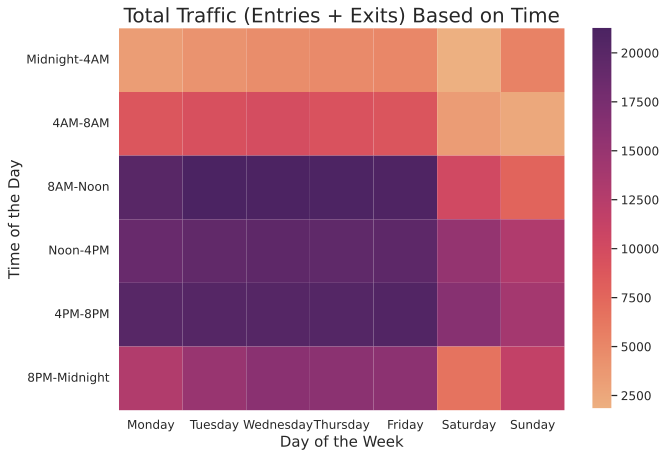

In [135]:
heat_map_ready = DF_for_heatm.set_index('TIME_OF_DAY')
plt.figure(figsize = [10,10])
chart = sns.heatmap(heat_map_ready, cmap = 'flare', square = True,cbar_kws={"shrink": .70});
plt.title('Total Traffic (Entries + Exits) Based on Time', size = 20); 
plt.xlabel('Day of the Week', size = 15);
plt.ylabel('Time of the Day', size = 15);
chart.set_yticklabels(chart.get_yticklabels(), rotation = 0);
plt.ylim([6, 0]);

In [136]:
def day_of_week_df(DAY_OF_WEEK, top):
    '''
    -MY final step is to detmine which stations are busiest depending on the day of the week
    -I am going to create a new mask and apply it to my previous database and assign that to a new var
    -we can then get summary statistics on that and sort from highest to lowest
    -I am on a bit of a time crunch, so I'm not sure if I will get these into bar plots
    
    '''
    mask = spring19_MTA_cleaned['DAY_OF_WEEK'] == DAY_OF_WEEK
    top_stations = (spring19_MTA_cleaned[mask].groupby('Unique_Station')
                       .sum() #sum all traffic
                       .sort_values(by = 'Total_Traffic', ascending = False)) #sort in descending to get top stations first
    
    return top_stations.head(top)

In [137]:
top_stations_monday = day_of_week_df('Monday', top = 5)
top_stations_tuesday = day_of_week_df('Tuesday', top = 5)
top_stations_wednesday = day_of_week_df('Wednesday', top = 5)
top_stations_thursday = day_of_week_df('Thursday', top = 5)
top_stations_friday = day_of_week_df('Friday', top = 5)

In [126]:
top_stations_monday[0:6]

,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
Unique_Station,,,,,,
34 ST-PENN STA_ACE,101313411949,107107593280,835980.0,635113.0,1320.703870,51693
FULTON ST_2345ACJZ,45949100195,50814733535,667356.0,654561.0,1186.118812,47552
GRD CNTRL-42 ST_4567S,92451949389,80824378449,661574.0,646433.0,1174.043204,39547
34 ST-HERALD SQ_BDFMNQRW,133176610183,123388039232,560710.0,572561.0,1017.281728,39713
42 ST-PORT AUTH_ACENQRS1237W,236470537672,191832685682,604793.0,329850.0,839.203420,29615


In [127]:
top_stations_tuesday[0:6]

,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
Unique_Station,,,,,,
34 ST-PENN STA_ACE,91546886225,97230855978,839286.0,673230.0,1358.046805,50662
FULTON ST_2345ACJZ,42568607537,46799611292,724132.0,687760.0,1267.198920,46356
GRD CNTRL-42 ST_4567S,87738288203,73211430976,688938.0,648527.0,1200.740774,37697
34 ST-HERALD SQ_BDFMNQRW,129609550055,119794590062,604702.0,600744.0,1082.275428,39198
42 ST-PORT AUTH_ACENQRS1237W,205836958221,165094194826,559557.0,319539.0,789.292529,27837


In [128]:
top_stations_wednesday[0:6]

,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
Unique_Station,,,,,,
34 ST-PENN STA_ACE,91297906684,97187733731,863916.0,697781.0,1402.323132,50384
FULTON ST_2345ACJZ,44375020237,48592956488,734667.0,714270.0,1300.512151,46884
GRD CNTRL-42 ST_4567S,87479371619,81512701487,693330.0,682552.0,1235.194419,40339
34 ST-HERALD SQ_BDFMNQRW,135529621267,127955414482,596666.0,609050.0,1082.528353,38047
PATH NEW WTC_1,242934588,288049644,471136.0,444399.0,821.539154,34960


In [129]:
top_stations_thursday[0:6]

,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
Unique_Station,,,,,,
34 ST-PENN STA_ACE,90143974084,95443536947,852246.0,685406.0,1380.734473,49532
FULTON ST_2345ACJZ,42687662075,47232349004,741583.0,703031.0,1296.648965,46536
GRD CNTRL-42 ST_4567S,84056275059,71374147734,691158.0,665692.0,1218.220522,36801
34 ST-HERALD SQ_BDFMNQRW,134673382088,125299313804,604659.0,608472.0,1089.283528,37256
42 ST-PORT AUTH_ACENQRS1237W,182389067825,152211804263,572982.0,324615.0,805.963996,27225


In [130]:
top_stations_friday[0:6]

,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
Unique_Station,,,,,,
34 ST-PENN STA_ACE,93197851604,98443951065,862872.0,703896.0,1406.901890,50448
GRD CNTRL-42 ST_4567S,90696966123,78178920013,787343.0,731790.0,1363.755176,44193
FULTON ST_2345ACJZ,46896365602,52139423962,750713.0,717044.0,1317.299730,49222
34 ST-HERALD SQ_BDFMNQRW,139546947419,133751402282,639310.0,644202.0,1152.538254,38329
42 ST-PORT AUTH_ACENQRS1237W,206159659154,176582767343,613868.0,350067.0,865.606661,27981
